In [170]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from experiments.config import PolimiHouse, ARAS, VanKastareen, DAMADICS, CovtFD, scoring
from src.furaki.tree import FurakiTree

In [171]:
# params = PolimiHouse
# params = ARAS
# params = VanKastareen   # ???
params = DAMADICS       # Buono da vedere
# params = CovtFD         # Troppe label

In [172]:
df = pd.read_csv(params.get('dataset'))
y = df.drifting.to_list()
X = df.drop("drifting", axis=1)

tree = FurakiTree(**params)
tree.fit(X)
labels = np.array(tree.predict())

print(params.get("dataset")[5:-4],'F1', scoring['F1'](y, labels, average='macro'))
print(params.get("dataset")[5:-4],'ARI', scoring['ARI'](y, labels))

DAMADICS F1 0.2980247624317374
DAMADICS ARI 0.18085474873610247


In [173]:
def hierarchy_pos_centered(G, root=None, x=0, y=0, dx=1.0, dy=1.0, pos=None, level=0):
    if pos is None:
        pos = {}

    children = list(G.successors(root))
    
    if not children:
        pos[root] = (x, y)
    else:
        # Posizionamento ricorsivo dei figli
        child_x = x - dx * (len(children) - 1) / 2  # centrare figli
        child_positions = []

        for child in children:
            pos = hierarchy_pos_centered(G, root=child, x=child_x, y=y - dy, dx=dx, dy=dy, pos=pos, level=level+1)
            child_positions.append(pos[child][0])
            child_x += dx

        # Centrare il padre rispetto alla media delle x dei figli
        min_x = min(child_positions)
        max_x = max(child_positions)
        pos[root] = ((min_x + max_x) / 2, y)

    return pos

C:\Users\zanno\AppData\Local\Temp\ipykernel_2632\2550658002.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


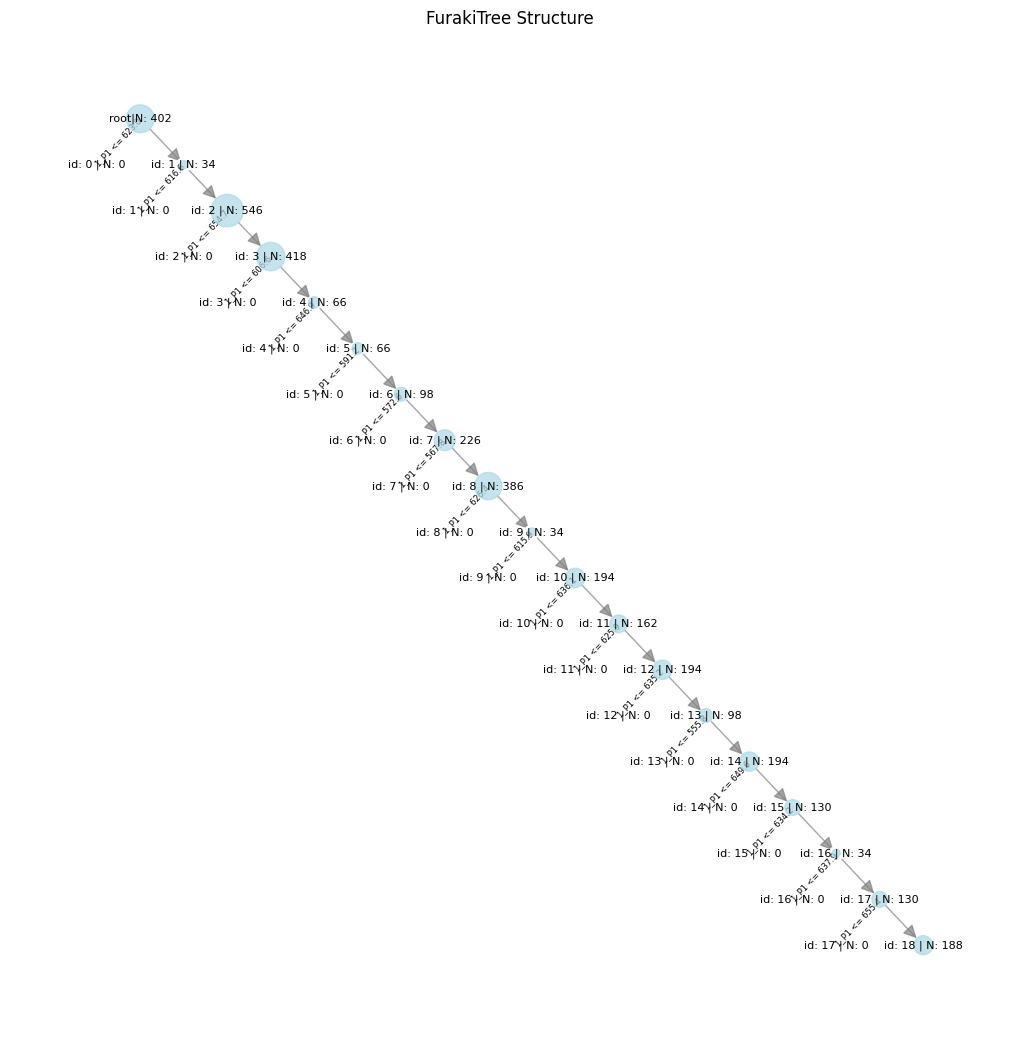

In [174]:
G = tree.to_networkx()
root = [n for n,d in G.in_degree() if d==0][0]
pos = hierarchy_pos_centered(G, root=root, x=0, y=0, dx=1.0, dy=1.5)

# Create the plot
plt.figure(figsize=(10,10))

# Extract node information
node_sizes = []
node_colors = []
node_labels = {}

for node_id in G.nodes():
    node_data = G.nodes[node_id]
    
    # Size based on sample count
    size = node_data.get('size', 1) #* 10
    node_sizes.append(size)
    
    # Clean label
    label = node_data.get('label', '').replace('{', '').replace('}', '')
    node_labels[node_id] = label

# Draw the tree
nx.draw(G, pos, 
        node_size=node_sizes,
        node_color='lightblue',
        with_labels=False,
        arrows=True,
        arrowsize=20,
        edge_color='gray',
        alpha=0.7)

# Add labels
nx.draw_networkx_labels(G, pos, node_labels, font_size=8)

# Add edge labels (split conditions)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=6)

plt.title("FurakiTree Structure")
plt.axis('off')
plt.tight_layout()
plt.show()

In [175]:
nodes = tree.get_nodes()
counts = [node.count for node in nodes]

print(np.sum(counts))
print(len(df))

3600
3600


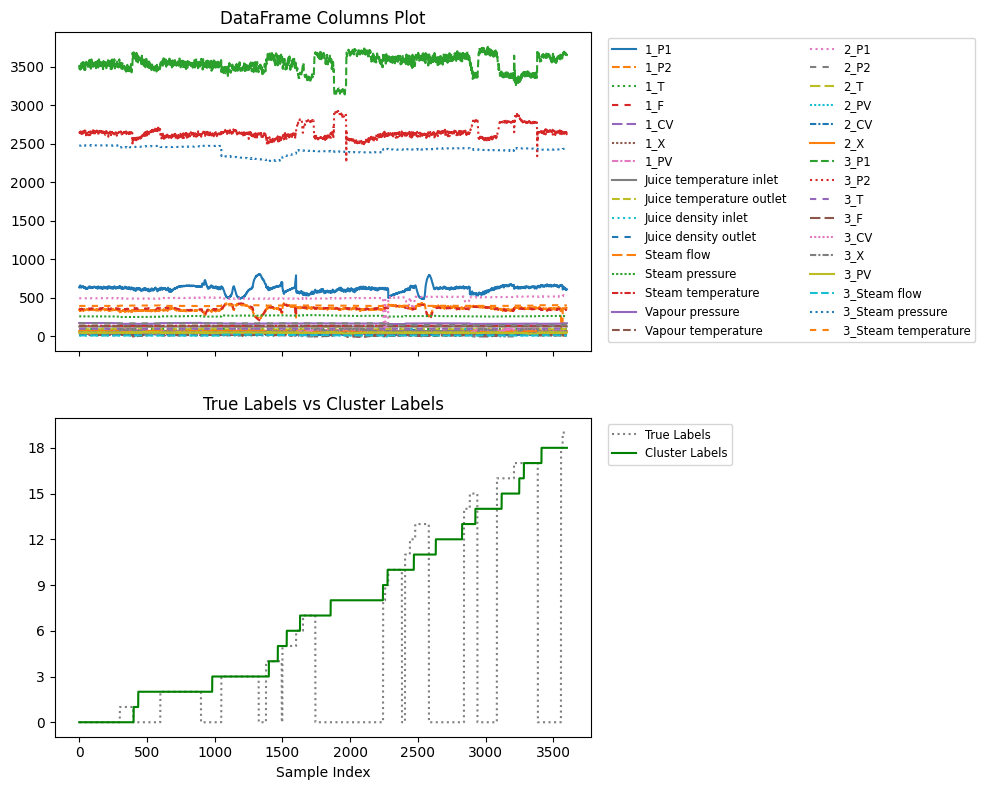

In [176]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
linestyles = ['-', '--', ':', (0, (3, 3)), (0, (5, 2)), (0, (1, 1)), (0, (3, 1, 1, 1))]

# First subplot
for i, col in enumerate(X.columns):
    axes[0].plot(X[col], label=col, linestyle=linestyles[i % len(linestyles)])
axes[0].set_title("DataFrame Columns Plot")

axes[0].legend(
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize='small',
    ncol=2,
)

# Second subplot
axes[1].plot(y, linestyle='dotted', color='gray', label='True Labels')
axes[1].plot(labels, color='green', label='Cluster Labels')
axes[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].set_title("True Labels vs Cluster Labels")

axes[1].legend(
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    fontsize='small',
    ncol=1
)

plt.xlabel("Sample Index")
plt.tight_layout()
plt.show()